In [7]:
import numpy as np
import uproot 
import scipy.interpolate as spi 
from statsmodels.nonparametric.smoothers_lowess import lowess
import os
import glob
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("~/evanstyle.mplstyle") #comment this if you're not evan! Or put your own style

# Description:
### The raw data of linearity calibration takes significant processing that only needs doing once. Evan can't figure out the structure of this super big Calibration_And_Test.py file but has figured out a concise way to pre-process the linearity data to make it so that during waveform analysis, calibration is fast. This notebook performs that preprocessing and just saves the output data as another tree in the calibrations root file

In [2]:
def preprocess_linearity_data(calib_file):
	adc_to_mv = np.zeros((30,256,4096))
	with uproot.open(calib_file) as f:
		voltage_counts = np.reshape(f["config_tree"]["voltage_count_curves"].array(library="np"), (30,256,256,2))

	#get the applied ADC count output of the DAC, which is the same for all channels... 
	applied_adcs = voltage_counts[0,0,:,0]
	#there is an assumption that this ADC count is related to the mV applied
	#based on the data sheet of 1200 mV for 4096 ADC counts. 
	assumed_DAC_scaling = 1200.0/4096

	#the output voltages are NOT monotonic, nor are they a single-valued
	#function of the input, the number of ADC counts sensed by the PSEC input. 
	#There is a statistical method called Locally Estimated Scatterplot Smoothing (LOESS)
	#that looks in local regions of the input space to produce a smooth output. 
	#We then form a linear interpolation object that can take an arbitrary ADC count. 
	#Then produce the mapping from the 4096 possible sensed ADC counts to the mV applied. 
	neighborhood_samples = 3.0 #number of samples to use in the LOESS smoothing
	frac = neighborhood_samples/len(applied_adcs) #fraction of the input space to use in the smoothing
	possible_sensed_adcs = np.arange(0, 4096, 1)
	for ch in range(len(voltage_counts)):
		for cap in range(len(voltage_counts[ch])):
			sensed_adcs = voltage_counts[ch,cap,:,1] #256 tested values, outputs measured by chip
			#LOESS smoothing. This returns a 256 length array of smoothed values matching the sensed adcs list. 
			#This essentially replaces a spline fit, or other methods that may not be as accurate
			smoothed = lowess(applied_adcs, sensed_adcs, frac=frac, return_sorted=False)
			#if the input is outside of the range, for example if you get 4095 adc counts sensed,
			#but only up to 4080 was tested, take the endpoints as the ouput value. 
			fill_values = (smoothed[0], smoothed[-1])
			temp_interp = spi.interp1d(sensed_adcs, smoothed, kind="linear", fill_value=fill_values, bounds_error=False)
			adc_to_mv[ch][cap] = temp_interp(possible_sensed_adcs)*assumed_DAC_scaling
	return adc_to_mv #(30, 256, 4096) = mV
		

In [11]:
datadir = "../../data/calibrations/"
calfiles = glob.glob(datadir+"*.root")

for calib_file in calfiles:
	print("Working on file ", calib_file)
	#check if it exists
	if(os.path.exists(calib_file)):
		adc_to_mv = preprocess_linearity_data(calib_file)
		#save to the root file as a new branch WITHOUT deleting the existing content in the tree.
		#sadly this is harder than it would seem in uproot...
		with uproot.open(calib_file) as f:
			tree = f["config_tree"]
			data = tree.arrays()

		data["adc_to_mv"] = adc_to_mv #add new branch to the tree
		with uproot.recreate(calib_file) as f:
			f["config_tree"] = data #resave it

Working on file  ../../data/calibrations/acdc61.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc67.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc49.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc44.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc43.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


Working on file  ../../data/calibrations/acdc54.root


/Users/ejangelico/anaconda3/envs/llnl/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


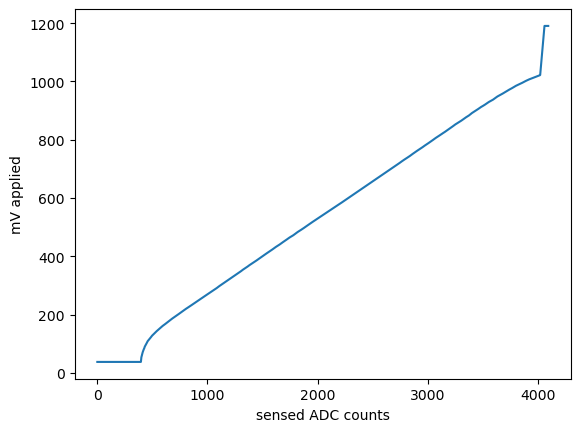

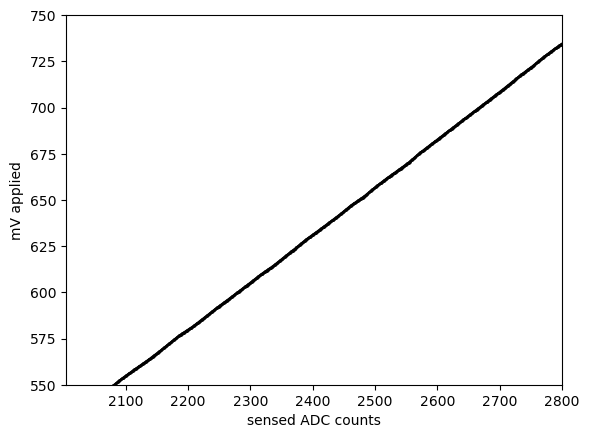

In [3]:
#check an example
datadir = "../../data/calibrations/"
calfiles = glob.glob(datadir+"*.root")
calib_file = calfiles[0]
with uproot.open(calib_file) as f:
	adc_to_mv = f["config_tree"]["adc_to_mv"].array(library="np")
	
adc_to_mv = np.reshape(adc_to_mv, (30,256,4096))



fig, ax = plt.subplots()
ax.plot(np.arange(0, 4096, 1), adc_to_mv[0][0])
ax.set_xlabel("sensed ADC counts")
ax.set_ylabel("mV applied")
plt.show()

fig, ax = plt.subplots()
ax.plot(np.arange(0, 4096, 1), adc_to_mv[0][0], 'ko-', markersize=1)
ax.set_xlim([2004, 2800])
ax.set_ylim([550,750])
ax.set_xlabel("sensed ADC counts")
ax.set_ylabel("mV applied")
plt.show()

In [10]:
#check an example
calib_file = calfiles[0]
with uproot.open(calib_file) as f:
	adc_to_mv = f["config_tree"]["voltage_count_curves"].array(library="np")

print(adc_to_mv.shape)

(30, 256, 256, 2)


# Piecing the timebase from one file to another

In [10]:
#Jin sent new root files with actual timebase info and I want to merge that timebase info into the master root files
tb_file = "/Users/ejangelico/Downloads/acdc44_timebase.root"
calfile = "../../data/calibrations/acdc44.root"
with uproot.open(tb_file) as f:
	tb = f["config_tree"]["time_offsets"].array(library="np")

with uproot.open(calfile) as f:
	data = f["config_tree"].arrays()

data["time_offsets"] = tb
with uproot.recreate(calfile) as f:
	f["config_tree"] = data #resave it


# In most cases, all samples are within the linear range of operation
### So we will fit that region to a line, define a range based on where the residuals start to explode, and store that into the calibration files as well
## Note: a threshold is set for the squared residual of the line fit, so that the "linear region" is defined as a region where the linear fit has a residue better than 5 mV squared

In [17]:
#check an example
datadir = "../../data/calibrations/"
calfiles = glob.glob(datadir+"*.root")
calib_file = calfiles[0]
with uproot.open(calib_file) as f:
	adc_to_mv = f["config_tree"]["adc_to_mv"].array(library="np")
	
adc_to_mv = np.reshape(adc_to_mv, (30,256,4096))

adc_sensed = np.arange(0, 4096, 1)

#############**
residue_threshold = 25 #5 mV, squared
linearity_lowers = []
linearity_uppers = []
ms = []
bs = []
for ch in range(30):
	print("On ch ", ch)
	for cap in range(256):
		sig = adc_to_mv[ch][cap]
		fit_range = [4096/2 - 1000, 4096/2 + 1000]
		fit_x = adc_sensed[np.where((adc_sensed >= fit_range[0]) & (adc_sensed <= fit_range[1]))]
		fit_y = sig[np.where((adc_sensed >= fit_range[0]) & (adc_sensed <= fit_range[1]))]
		m, b = np.polyfit(fit_x, fit_y, 1)
		ms.append(m)
		bs.append(b)

		#calculate residuals over the whole range
		residuals = (sig - (m*adc_sensed + b))**2
		linear_range = [None, None]

		#get a list of adc_sensed and residuals that start from the middle
		#of the range and decrease to 0 adc_sensed
		mid_adc_sensed_rev = adc_sensed[:int(4096/2)] 
		mid_adc_sensed_rev = mid_adc_sensed_rev[::-1]
		mid_residuals_rev = residuals[:int(4096/2)]
		mid_residuals_rev = mid_residuals_rev[::-1]
		#find the first value that goes above the thresold
		threshold_idx = np.where(mid_residuals_rev > residue_threshold)[0]
		if(len(threshold_idx) == 0):
			threshold_idx = 0
		else:
			threshold_idx = threshold_idx[0]
		
		linear_range[0] = mid_adc_sensed_rev[threshold_idx]

		#do the same but for the other half
		mid_adc_sensed = adc_sensed[int(4096/2):] 
		mid_residuals = residuals[int(4096/2):]
		#find the first value that goes above the thresold
		threshold_idx = np.where(mid_residuals > residue_threshold)[0]
		if(len(threshold_idx) == 0):
			threshold_idx = -1
		else:
			threshold_idx = threshold_idx[0]

		
		linear_range[1] = mid_adc_sensed[threshold_idx]

		linearity_lowers.append(linear_range[0])
		linearity_uppers.append(linear_range[1])

		"""
		fig, ax = plt.subplots()
		ax.plot(adc_sensed, sig)
		ax.plot(fit_x, m*fit_x + b, 'r--')
		ax.set_xlabel("sensed ADC counts")
		ax.set_ylabel("mV applied")
		plt.show()

		fig, ax = plt.subplots()
		ax.plot(adc_sensed, residuals)
		ax.axhline(residue_threshold, color='r', linestyle='--')
		ax.axvline(linear_range[0], color='r', linestyle='--')
		ax.axvline(linear_range[1], color='r', linestyle='--')
		ax.set_xlabel("squared residual")
		ax.set_ylabel("mV applied")
		ax.set_ylim([0, 30])
		plt.show()
		"""


On ch  0
On ch  1
On ch  2
On ch  3
On ch  4
On ch  5
On ch  6
On ch  7
On ch  8
On ch  9
On ch  10
On ch  11
On ch  12
On ch  13
On ch  14
On ch  15
On ch  16
On ch  17
On ch  18
On ch  19
On ch  20
On ch  21
On ch  22
On ch  23
On ch  24
On ch  25
On ch  26
On ch  27
On ch  28
On ch  29


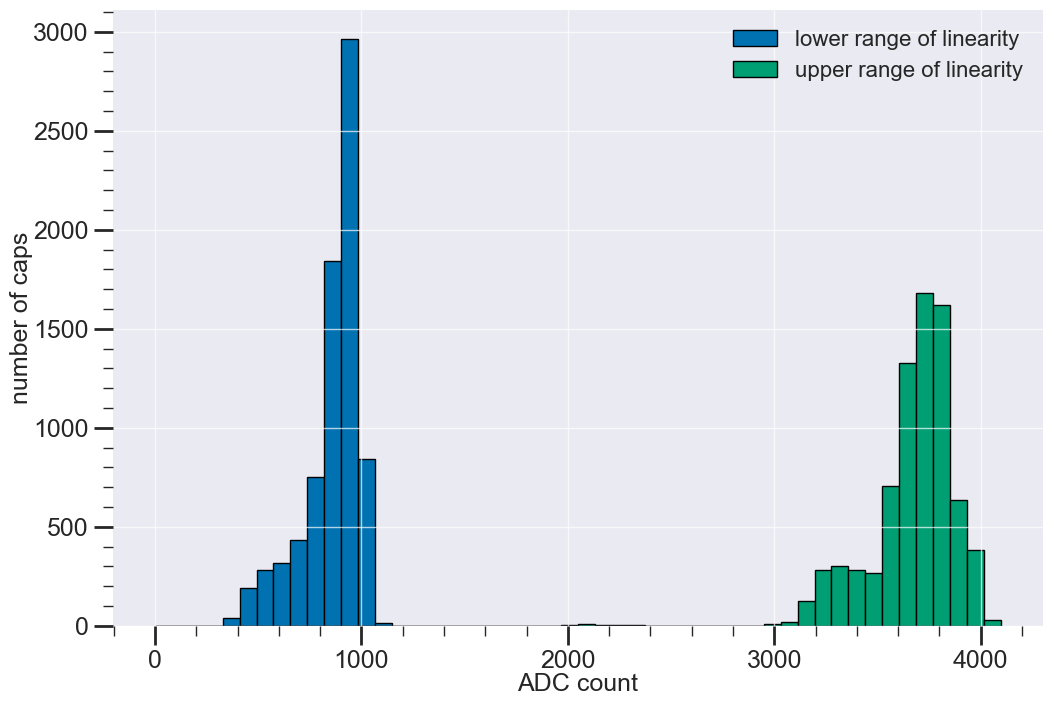

In [19]:
fig, ax = plt.subplots()
ax.hist(linearity_lowers, bins=50, range=[0, 4096], label='lower range of linearity')
ax.hist(linearity_uppers, bins=50, range=[0, 4096], label="upper range of linearity")
ax.set_xlabel("ADC count")
ax.set_ylabel("number of caps")
ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


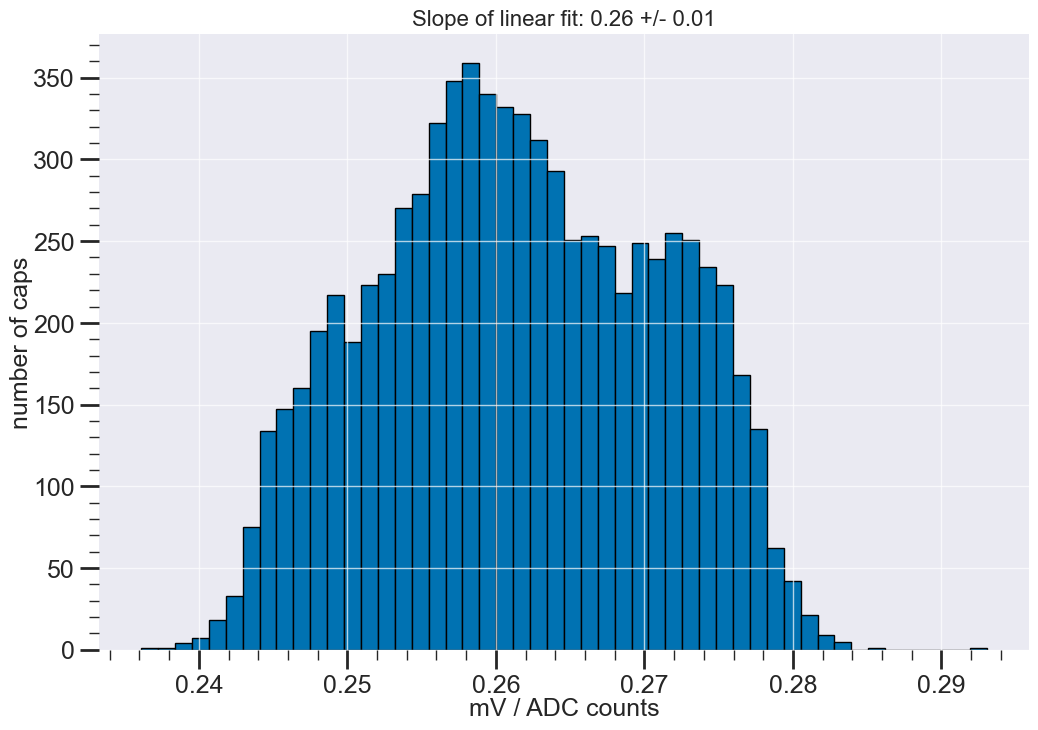

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


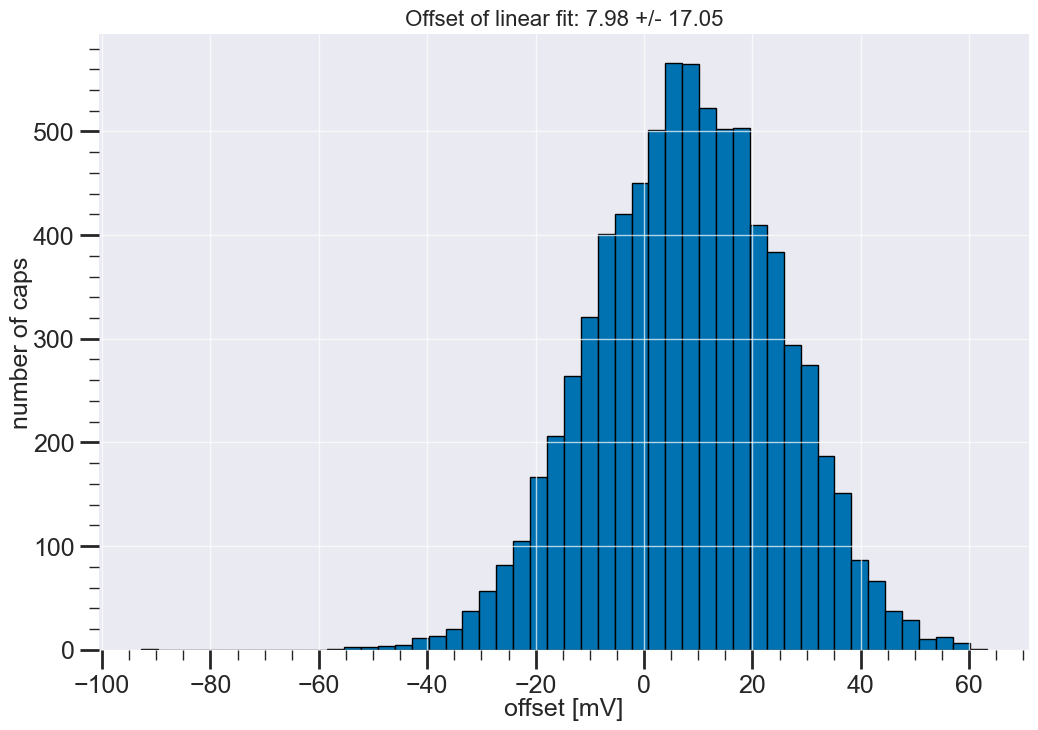

In [26]:
fig, ax = plt.subplots()
ax.hist(ms, bins=50)
ax.set_xlabel("mV / ADC counts")
ax.set_ylabel("number of caps")
ax.set_title("Slope of linear fit: {:.2f} +/- {:.2f}".format(np.mean(ms), np.std(ms)))
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.hist(bs, bins=50)
ax.set_xlabel("offset [mV]")
ax.set_ylabel("number of caps")
ax.set_title("Offset of linear fit: {:.2f} +/- {:.2f}".format(np.mean(bs), np.std(bs)))
ax.legend()
plt.show()

# All of that was just debugging, here is the actual analysis that stores the new root branches

In [29]:
#check an example
datadir = "../../data/calibrations/"
calfiles = glob.glob(datadir+"*.root")
calib_file = calfiles[1]
with uproot.open(calib_file) as f:
	adc_to_mv = f["config_tree"]["adc_to_mv"].array(library="np")
	
adc_to_mv = np.reshape(adc_to_mv, (30,256,4096))

adc_sensed = np.arange(0, 4096, 1)

#############**
residue_threshold = 25 #5 mV, squared
slopes = np.zeros((30,256))
offsets = np.zeros((30,256))
ranges = np.zeros((30,256,2))

for ch in range(30):
	print("On ch ", ch)
	for cap in range(256):
		sig = adc_to_mv[ch][cap]
		fit_range = [4096/2 - 1000, 4096/2 + 1000]
		fit_x = adc_sensed[np.where((adc_sensed >= fit_range[0]) & (adc_sensed <= fit_range[1]))]
		fit_y = sig[np.where((adc_sensed >= fit_range[0]) & (adc_sensed <= fit_range[1]))]
		m, b = np.polyfit(fit_x, fit_y, 1)

		#calculate residuals over the whole range
		residuals = (sig - (m*adc_sensed + b))**2
		linear_range = [None, None]

		#get a list of adc_sensed and residuals that start from the middle
		#of the range and decrease to 0 adc_sensed
		mid_adc_sensed_rev = adc_sensed[:int(4096/2)] 
		mid_adc_sensed_rev = mid_adc_sensed_rev[::-1]
		mid_residuals_rev = residuals[:int(4096/2)]
		mid_residuals_rev = mid_residuals_rev[::-1]
		#find the first value that goes above the thresold
		threshold_idx = np.where(mid_residuals_rev > residue_threshold)[0]
		if(len(threshold_idx) == 0):
			threshold_idx = 0
		else:
			threshold_idx = threshold_idx[0]
		
		linear_range[0] = mid_adc_sensed_rev[threshold_idx]

		#do the same but for the other half
		mid_adc_sensed = adc_sensed[int(4096/2):] 
		mid_residuals = residuals[int(4096/2):]
		#find the first value that goes above the thresold
		threshold_idx = np.where(mid_residuals > residue_threshold)[0]
		if(len(threshold_idx) == 0):
			threshold_idx = -1
		else:
			threshold_idx = threshold_idx[0]

		
		linear_range[1] = mid_adc_sensed[threshold_idx]

		slopes[ch][cap] = m
		offsets[ch][cap] = b
		ranges[ch][cap] = linear_range


On ch  0
On ch  1
On ch  2
On ch  3
On ch  4
On ch  5
On ch  6
On ch  7
On ch  8
On ch  9
On ch  10
On ch  11
On ch  12
On ch  13
On ch  14
On ch  15
On ch  16
On ch  17
On ch  18
On ch  19
On ch  20
On ch  21
On ch  22
On ch  23
On ch  24
On ch  25
On ch  26
On ch  27
On ch  28
On ch  29


In [30]:

with uproot.open(calib_file) as f:
	data = f["config_tree"].arrays()

data["lin_slopes"] = slopes
data["lin_offsets"] = offsets
data["lin_ranges"] = ranges

with uproot.recreate(calib_file) as f:
	f["config_tree"] = data #resave it
